In [1]:
import stanza
import graphviz
import os
import json

import networkx as nx
import pandas as pd
import numpy as np

from potato.dataset.dataset import Dataset
from potato.models.trainer import GraphTrainer
from tuw_nlp.grammar.text_to_4lang import TextTo4lang
from tuw_nlp.graph.fourlang import FourLang
from tuw_nlp.text.pipeline import CachedStanzaPipeline, CustomStanzaPipeline
from graphviz import Source

In [2]:
config = {
    "lang": "en",
    "depth": 0,
    "substitute": False,
    "nr of samples": 0,
}
data = {
 "dir": "data"
}

In [3]:
GOLD_ATTRIBUTES = "gold_attributes"
GOLD = "labels_gold"
ANNOTATED_ATTRIBUTES = "annotated_attributes"

def create_input(directory, attribute):
    sentence = []
    label = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), "rt") as f:
            doc = json.load(f)
            for sen in doc["sens"].values():
                if doc[GOLD]:
                    lab = attribute in sen[GOLD_ATTRIBUTES]
                else:
                    lab = attribute in sen[ANNOTATED_ATTRIBUTES]
                sentence.append(sen["text"])
                label.append(lab)
    return pd.DataFrame(data=list(zip(sentence,label)),columns=["Text","Label"])



In [4]:
#Load in Data for specific feature
train_data = create_input(os.path.join(data["dir"], "train"), "Planzeichen")

#Save the labels for later. In this case its just 0,1 conversion for Planzeichen
labels = train_data.Label*1

train_data = train_data.drop([6020])

train_data

,Text,Label
0,Unverkäufliches Dienstexemplar!,False
1,M A G I S T R A T D E R S T A D T W I E N MA 2...,False
2,Der Gemeinderat hat in seiner Sitzung am 29. J...,False
3,"Bezirk, Kat. G. Stammersdorf werden unter Anwe...",False
4,Der bisher gültige Flächenwidmungsplan und Beb...,False
...,...,...
8941,Bei Errichtung unterirdischer Bauwerke sind Vo...,False
8942,Bestimmungen mit Bezeichnung des Geltungsberei...,True
8943,Für die mit BB1 bezeichnete Grundfläche wird b...,True
8944,Für die mit BB2 bezeichnete Grundfläche wird b...,True


In [5]:
sentences = [(row["Text"], str(row["Label"])) for _, row in train_data.iterrows()]

    
sentences

[('Unverkäufliches Dienstexemplar!', 'False'),
 ('M A G I S T R A T D E R S T A D T W I E N MA 21 C Stadtteilplanung und Flächennutzung Nordost Plandokument 7283 Festsetzung des Flächenwidmungsplanes und des Bebauungsplanes',
  'False'),
 ('Der Gemeinderat hat in seiner Sitzung am 29. Juni 2000, Pr. Zl. 130 GPZ/2000, den folgenden Beschluss gefasst: In Festsetzung des Flächenwidmungsplanes und des Bebauungsplanes für das im Antragsplan Nr. 7283 mit der rot strichpunktierten Linie oder den in roter Schrift als „Plangebietsgrenze“ bezeichneten Fluchtlinien umschriebene Gebiet zwischen Stammersdorfer Straße 216-242 und Linienzug 1-6 im 21.',
  'False'),
 ('Bezirk, Kat. G. Stammersdorf werden unter Anwendung des § 1 der BO für Wien folgende Bestimmungen getroffen:',
  'False'),
 ('Der bisher gültige Flächenwidmungsplan und Bebauungsplan verliert seine weitere Rechtskraft.',
  'False'),
 ('Die roten Planzeichen gelten als neu festgesetzt.', 'False'),
 ('Für die rechtliche Bedeutung der Plan

In [6]:
dataset = Dataset(sentences, label_vocab={str(False): 0, str(True): 1})
dataset.set_graphs(dataset.parse_graphs(graph_format="fourlang"))
dataset

2021-11-08 17:33:09 WARNING: Can not find mwt: default from official model list. Ignoring it.
2021-11-08 17:33:09 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2021-11-08 17:33:09 INFO: Use device: gpu
2021-11-08 17:33:09 INFO: Loading: tokenize
2021-11-08 17:33:10 INFO: Loading: pos
2021-11-08 17:33:11 INFO: Loading: lemma
2021-11-08 17:33:11 INFO: Loading: depparse
2021-11-08 17:33:11 INFO: Done loading processors!
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8945/8945 [01:37<00:00, 91.83it/s]


In [7]:
df = dataset.to_dataframe()
df

,text,label,label_id,graph
0,Unverkäufliches Dienstexemplar!,False,0,(0)
1,M A G I S T R A T D E R S T A D T W I E N MA 2...,False,0,"(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,Der Gemeinderat hat in seiner Sitzung am 29. J...,False,0,"(19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3..."
3,"Bezirk, Kat. G. Stammersdorf werden unter Anwe...",False,0,"(50, 51, 52, 53, 54, 55)"
4,Der bisher gültige Flächenwidmungsplan und Beb...,False,0,"(24, 56, 57)"
...,...,...,...,...
8940,Bei Errichtung unterirdischer Bauwerke sind Vo...,False,0,"(314, 3072, 1518, 71, 143, 3703, 156, 1199, 15..."
8941,Bestimmungen mit Bezeichnung des Geltungsberei...,True,1,"(211, 775, 110, 218, 406, 64)"
8942,Für die mit BB1 bezeichnete Grundfläche wird b...,True,1,"(58, 112, 352, 109, 110, 78, 25, 65, 2265, 287..."
8943,Für die mit BB2 bezeichnete Grundfläche wird b...,True,1,"(58, 176, 357, 435, 185, 356, 89, 217, 213, 61..."


In [8]:
trainer = GraphTrainer(df)
#extract features
trainer.prepare()

Initializing trainer object...
Featurizing graphs by generating subgraphs up to 2...


8945it [00:25, 355.01it/s]


Getting feature graphs...
Selecting the best features...


In [9]:
trainer.feature_graph_strings

['(u_0 / unverkyuflich)',
 '(u_1 / T)',
 '(u_1 / T  :0 (u_14 / A))',
 '(u_1 / T  :0 (u_16 / R))',
 '(u_1 / T  :1 (u_17 / I))',
 '(u_1 / T  :1 (u_18 / g))',
 '(u_1 / T  :0 (u_2 / C))',
 '(u_1 / T  :0 (u_9 / MA))',
 '(u_1 / T  :0 (u_10 / N))',
 '(u_1 / T  :0 (u_12 / W))',
 '(u_1 / T  :0 (u_13 / D))',
 '(u_15 / HAS  :2 (u_1 / T))',
 '(u_1 / T  :0 (u_14 / A)  :0 (u_16 / R))',
 '(u_1 / T  :0 (u_14 / A)  :1 (u_17 / I))',
 '(u_1 / T  :0 (u_14 / A)  :1 (u_18 / g))',
 '(u_1 / T  :0 (u_2 / C)  :0 (u_14 / A))',
 '(u_1 / T  :0 (u_9 / MA)  :0 (u_14 / A))',
 '(u_1 / T  :0 (u_10 / N)  :0 (u_14 / A))',
 '(u_1 / T  :0 (u_12 / W)  :0 (u_14 / A))',
 '(u_1 / T  :0 (u_13 / D)  :0 (u_14 / A))',
 '(u_1 / T  :0 (u_14 / A)  :2-of (u_15 / HAS))',
 '(u_1 / T  :0 (u_16 / R)  :1 (u_17 / I))',
 '(u_1 / T  :0 (u_16 / R)  :1 (u_18 / g))',
 '(u_1 / T  :0 (u_2 / C)  :0 (u_16 / R))',
 '(u_1 / T  :0 (u_9 / MA)  :0 (u_16 / R))',
 '(u_1 / T  :0 (u_10 / N)  :0 (u_16 / R))',
 '(u_1 / T  :0 (u_12 / W)  :0 (u_16 / R))',
 '(u_1

In [10]:
len(trainer.feature_graphs)

103777

<AxesSubplot:ylabel='Frequency'>

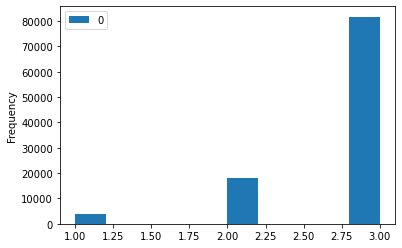

In [13]:
feature_graph_lens = [len(feature_graph) for feature_graph in trainer.feature_graphs]
data = pd.DataFrame(feature_graph_lens)
data.plot.hist()

<AxesSubplot:ylabel='Frequency'>

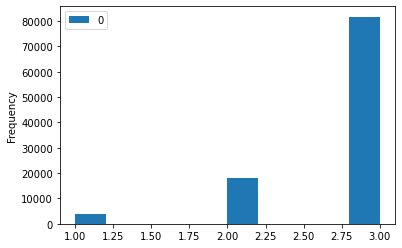

In [12]:
feature_graph_lens = [len(feature_graph) for feature_graph in trainer.feature_graphs]
data = pd.DataFrame(feature_graph_lens)
data.plot.hist()

<AxesSubplot:ylabel='Frequency'>

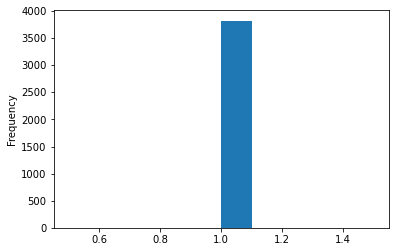

In [41]:
labels = pd.DataFrame([list(feature_graph.nodes(data=True))[0][1]["name"] for feature_graph in trainer.feature_graphs if len(feature_graph)==1])

labels.value_counts().plot.hist(bins=10)

<AxesSubplot:ylabel='Frequency'>

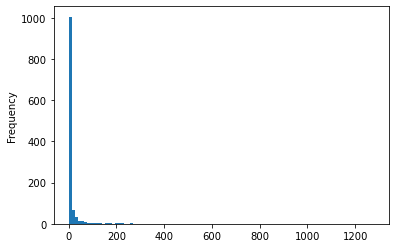

In [46]:
labels = pd.DataFrame([list(feature_graph.nodes(data=True))[0][1]["name"] for feature_graph in trainer.feature_graphs if len(feature_graph)==2])

labels.value_counts().plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

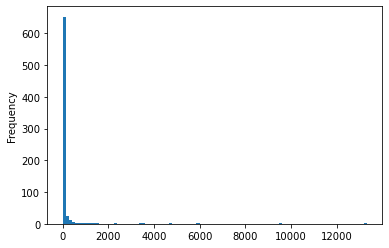

In [45]:
labels = pd.DataFrame([list(feature_graph.nodes(data=True))[0][1]["name"] for feature_graph in trainer.feature_graphs if len(feature_graph)==3])

labels.value_counts().plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

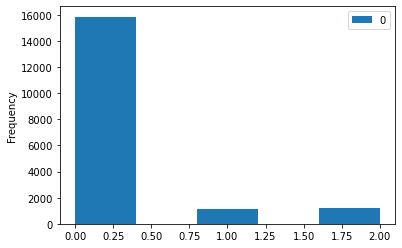

In [56]:
edges = pd.DataFrame([list(feature_graph.edges(data=True))[0][2]["color"] for feature_graph in trainer.feature_graphs if len(feature_graph)==2])

edges.plot.hist(bins=5)

<AxesSubplot:ylabel='Frequency'>

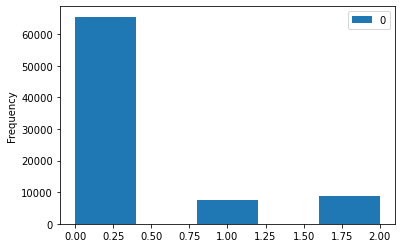

In [57]:
edges = pd.DataFrame([list(feature_graph.edges(data=True))[0][2]["color"] for feature_graph in trainer.feature_graphs if len(feature_graph)==3])

edges.plot.hist(bins=5)